In [9]:
import numpy as np

In [10]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *

from keras.datasets import fashion_mnist, mnist

In [11]:
from utils import *

# Loading and preparing data

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

# Parts definition

In [14]:
BATCH_SIZE = 128

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

### Encoder

In [15]:
inp_e = Input((INPUT_DIM,))
inp_e_noise = Input((LATENT_DIM,))
e = concatenate([inp_e, inp_e_noise])

e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM)(e)
           
encoder = Model([inp_e, inp_e_noise], e, name='encoder')

### Decoder

In [16]:
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)

d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

### Discriminator

In [17]:
inp_a = Input((LATENT_DIM,))
a = GradientReversal()(inp_a)
a = Dense(HIDDEN_DIM, activation='relu')(a)

a = Dense(1, activation='sigmoid')(a)

discriminator = Model(inp_a, a, name='discriminator')

## Stacking all together

In [20]:
data_inp = Input((INPUT_DIM,))
noise_inp = Input((LATENT_DIM,))

prior_distribution = Input((LATENT_DIM,))

z = encoder([data_inp, noise_inp])
data_reconstruction = decoder(z)

discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator(z))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator(prior_distribution))

model = Model([data_inp, noise_inp, prior_distribution], [data_reconstruction, discriminator_fake, discriminator_real])
model.compile('adam', 'binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            267266      input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 2)            0                                            
__________

## Training

In [21]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                encoder_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, encoder_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [22]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

In [23]:
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=128, verbose=2, 
                    callbacks=None, 
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/128
 - 11s - loss: 1.0673 - decoder_loss: 0.2768 - discriminator_fake_loss: 0.3988 - discriminator_real_loss: 0.3917 - val_loss: 2.1257 - val_decoder_loss: 0.2622 - val_discriminator_fake_loss: 1.5142 - val_discriminator_real_loss: 0.3493
Epoch 2/128
 - 10s - loss: 1.7033 - decoder_loss: 0.2499 - discriminator_fake_loss: 0.7913 - discriminator_real_loss: 0.6621 - val_loss: 1.6351 - val_decoder_loss: 0.2401 - val_discriminator_fake_loss: 0.6959 - val_discriminator_real_loss: 0.6991
Epoch 3/128
 - 10s - loss: 1.6308 - decoder_loss: 0.2316 - discriminator_fake_loss: 0.7030 - discriminator_real_loss: 0.6963 - val_loss: 1.6050 - val_decoder_loss: 0.2300 - val_discriminator_fake_loss: 0.6835 - val_discriminator_real_loss: 0.6914
Epoch 4/128
 - 10s - loss: 1.6228 - decoder_loss: 0.2261 - discriminator_fake_loss: 0.7011 - discriminator_real_loss: 0.6956 - val_loss: 1.6134 - val_decoder_loss: 0.2234 - val_discriminator_fake_loss: 0.6905 - val_discriminator_real_loss: 0.6995
Epoch 5/128


## Visualisation

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

Latent space image

In [26]:
batch = np.concatenate(np.mgrid[-1:1:20j, -1:1:20j].T, axis=0)
z_space_image = decoder.predict(batch).reshape((20, 20, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

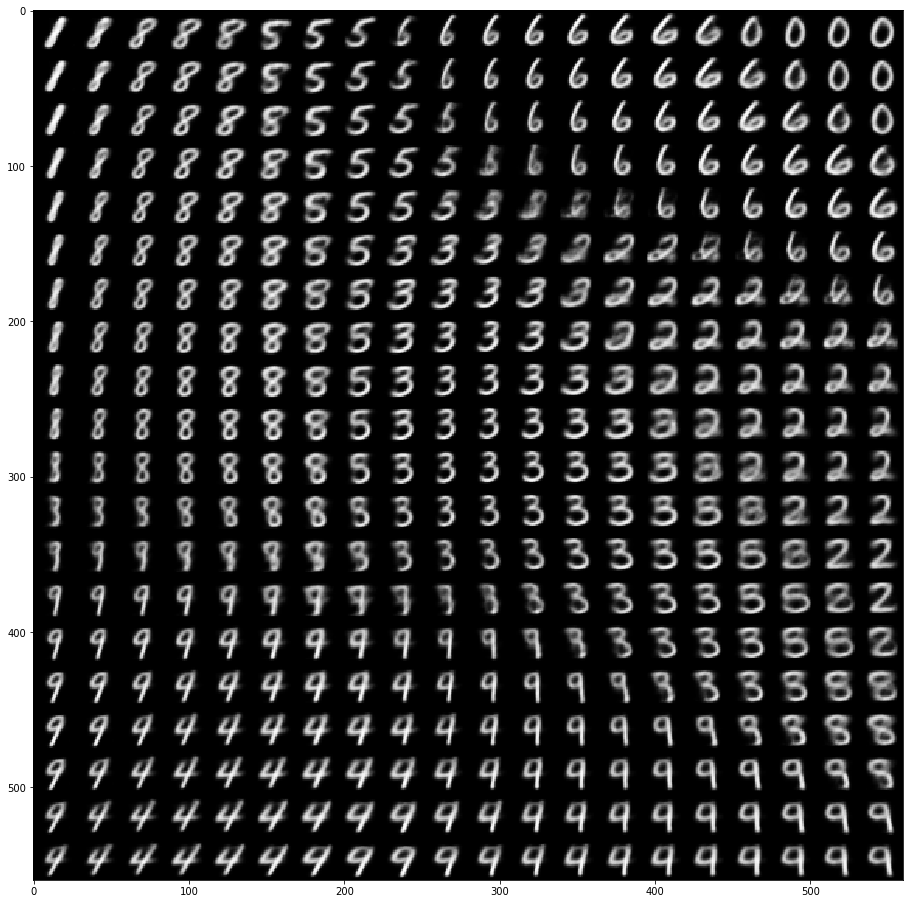

In [27]:
plt.figure(figsize=(16, 16))
plt.imshow(z_space_image, cmap='gray')

Latent space scatter

In [31]:
z_space_code = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
x, y = z_space_code.T

In [32]:
z_space_code.mean(), z_space_code.std()

(-0.013211704, 0.9809877)

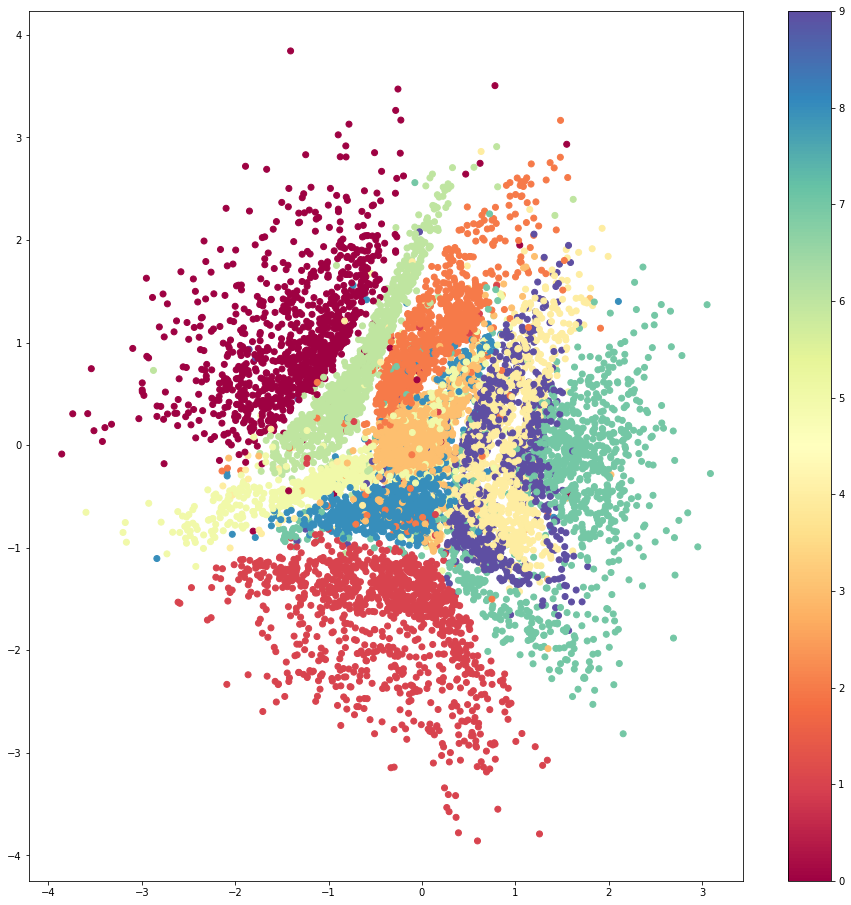

In [33]:
plt.figure(figsize=(16, 16))
plt.scatter(x, y, c=y_test, cmap=plt.cm.Spectral)
plt.colorbar()